In [33]:
import boto3
from dotenv import load_dotenv
import os
from io import StringIO 
import numpy as np
# Initialize an S3 client
s3_client = boto3.client('s3')


load_dotenv()

# Access the environment variables for AWS credentials
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
AWS_DEFAULT_REGION = os.getenv('AWS_DEFAULT_REGION')

s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

# Define the S3 bucket and the file path
bucket_name = 'isbfinanceproject'
def get_file_path(vertical, ticker):
    file_path = f"{vertical}/{ticker}/{ticker}_data.csv"
    return file_path

# Example usage
vertical = 'Pharmacy'  # Replace with the actual vertical
ticker = 'SUNPHARMA.NS'       # Replace with the actual ticker

# Get the file path
file_path = get_file_path(vertical, ticker)

# Download the file to the local system
try:
    s3_client.download_file(bucket_name, file_path, f"./{ticker}_data.csv")
    print(f"File {ticker}_data.csv downloaded successfully.")
except Exception as e:
    print(f"Error downloading file: {e}")

File SUNPHARMA.NS_data.csv downloaded successfully.


In [34]:
import pandas as pd
df = pd.read_csv(f"./{ticker}_data.csv")
df = df.drop([0, 1])
df = df.reset_index(drop=True)
df.tail()

,Price,Adj Close,Close,High,Low,Open,Volume
2461,2024-12-02 00:00:00+00:00,1808.550048828125,1808.550048828125,1814.0,1792.1500244140625,1800.0,1948045
2462,2024-12-03 00:00:00+00:00,1800.050048828125,1800.050048828125,1832.0,1788.3499755859375,1831.25,1543970
2463,2024-12-04 00:00:00+00:00,1800.199951171875,1800.199951171875,1814.8499755859375,1785.0,1810.5,2320116
2464,2024-12-05 00:00:00+00:00,1813.449951171875,1813.449951171875,1825.949951171875,1775.4000244140625,1808.699951171875,2742263
2465,2024-12-06 00:00:00+00:00,1804.8499755859375,1804.8499755859375,1823.949951171875,1801.0,1815.8499755859375,1590478


REMOVE THE PROCE COLUMN AS IT HAS TIMESTAMP SO WONT BE USED FOR DATA SCALING AND OTHER PURPOSES. WILL BE ADDED LATER WHILE BUILDING THE MODEL.

In [35]:
data = df[['Price']].copy()
df=df.drop(columns=['Price'])

In [36]:

df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

Noise Reduction (Removing Outliers & Irrelevant Data):

In [37]:
print(df.dtypes)

Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object


In [38]:
# Identify outliers using the Z-score method (e.g., 3 standard deviations away from the mean)
from scipy.stats import zscore

# Calculate Z-scores for the relevant columns (e.g., 'Close' price)
df['zscore'] = zscore(df['Close'])

# Filter out rows where the z-score is beyond 3 (or any threshold you prefer)
df_filtered = df[df['zscore'].abs() < 3]

Feature Engineering:


a. Lagged Stock Prices (Previous Day’s Price):

Essentially shift the stock's price by a certain number of time periods (e.g., days), which allows to incorporate past information into the model.

Example:
lag_1: The stock price on the previous day (shift(1))
lag_2: The stock price from two days ago (shift(2))
lag_7: The stock price from seven days ago (shift(7))


In [39]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_7'] = df['Close'].shift(7)

Moving average (7-day and 30-day)

In [40]:
df['ma_7'] = df['Close'].rolling(window=7).mean()
df['ma_30'] = df['Close'].rolling(window=30).mean()

Volatility indicators

# Analyzing Stock Data: Daily Returns and Volatility

This guide explains how to compute **daily returns** and **volatility** using stock price data, which can be fetched using the `yfinance` library.

---

## Daily Returns

The **daily return** measures the percentage change in the closing price of a stock from one trading day to the next. It provides insights into the stock's short-term performance.

### Formula:
\[
\text{Daily Return} = \frac{\text{Today's Close Price} - \text{Yesterday's Close Price}}{\text{Yesterday's Close Price}}
\]




In [41]:
df['daily_returns'] = df['Close'].pct_change()
df['volatility'] = df['daily_returns'].rolling(window=30).std()  # 30-day volatility

Check if data is normally distributed for z-score standardization

# Data Normalization Techniques: Z-Score and Min-Max Normalization

Normalization is a crucial step in preprocessing data for machine learning models. It ensures that all features contribute equally to the model, particularly when they are measured on different scales. This guide covers two common normalization techniques: **z-score normalization** and **min-max normalization**.

---

## Z-Score Normalization

**Z-score normalization** (also called standardization) transforms the data into a distribution with a mean of 0 and a standard deviation of 1. This method is particularly useful when the data has outliers or follows a Gaussian (normal) distribution.

### Formula:
\[
z = \frac{x - \mu}{\sigma}
\]

Where:
- \( x \): The data point.
- \( \mu \): The mean of the feature.
- \( \sigma \): The standard deviation of the feature.

### Key Features:
- Centers the data around zero.
- Scales features based on standard deviation, making it robust to varying units of measurement.
- Outliers will have higher or lower \( z \)-scores.

### Python Implementation:
```python
import pandas as pd

# Example DataFrame
df = pd.DataFrame({'Feature': [10, 20, 30, 40, 50]})

# Z-score normalization
df['z_score_normalized'] = (df['Feature'] - df['Feature'].mean()) / df['Feature'].std()
print(df)


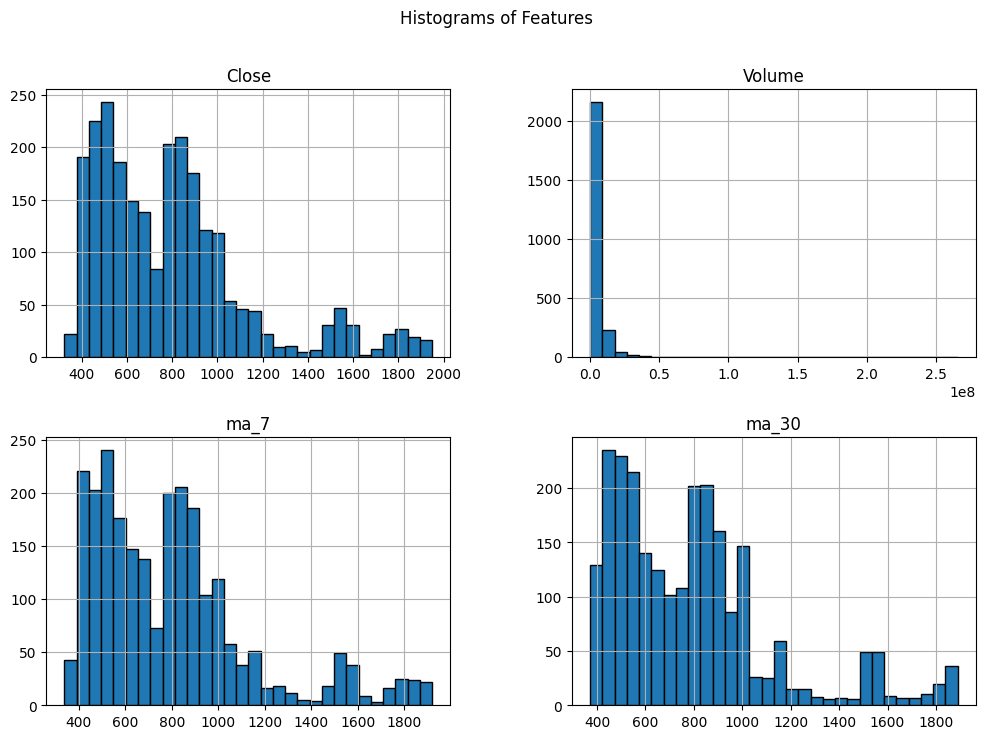

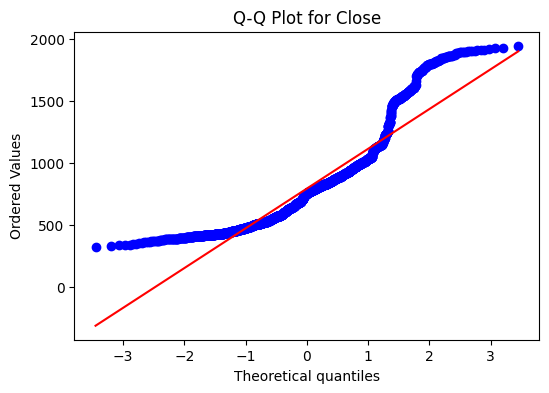

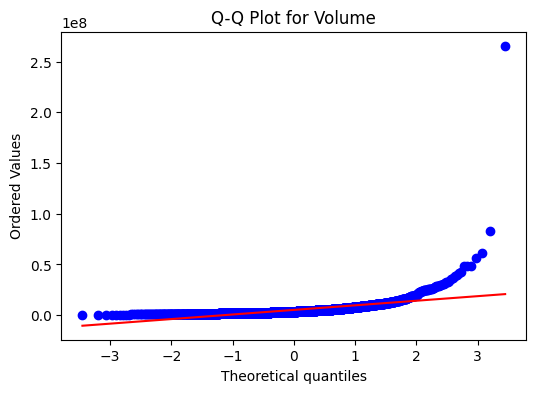

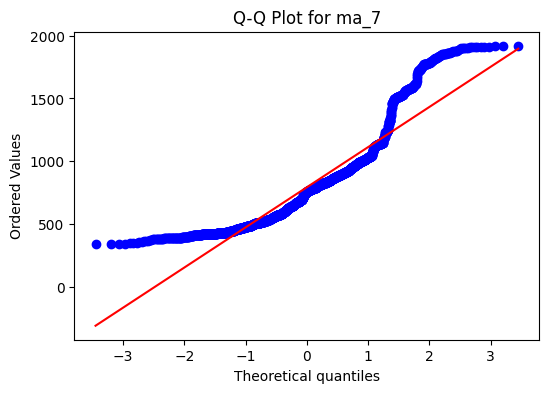

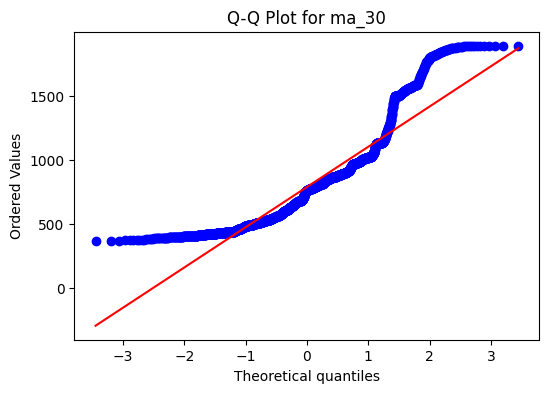

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Plot histograms for each of the features
features = ['Close', 'Volume', 'ma_7', 'ma_30']
df[features].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Histograms of Features')
plt.show()

# Q-Q plot for normality
for feature in features:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[feature].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {feature}')
    plt.show()

In [43]:
from scipy.stats import shapiro, kstest

# Shapiro-Wilk test for normality
for feature in features:
    stat, p_value = shapiro(df[feature].dropna())
    print(f'Shapiro-Wilk test for {feature}:')
    print(f'Statistic={stat}, p-value={p_value}')
    if p_value > 0.05:
        print(f'{feature} is normally distributed (fail to reject H0)\n')
    else:
        print(f'{feature} is not normally distributed (reject H0)\n')

# Kolmogorov-Smirnov test for normality
for feature in features:
    stat, p_value = kstest(df[feature].dropna(), 'norm')
    print(f'KS test for {feature}:')
    print(f'Statistic={stat}, p-value={p_value}')
    if p_value > 0.05:
        print(f'{feature} is normally distributed (fail to reject H0)\n')
    else:
        print(f'{feature} is not normally distributed (reject H0)\n')

Shapiro-Wilk test for Close:
Statistic=0.877130937601849, p-value=2.0901963805341656e-40
Close is not normally distributed (reject H0)

Shapiro-Wilk test for Volume:
Statistic=0.36492226589317556, p-value=1.3051375953623733e-68
Volume is not normally distributed (reject H0)

Shapiro-Wilk test for ma_7:
Statistic=0.8768044785376394, p-value=2.090286823870031e-40
ma_7 is not normally distributed (reject H0)

Shapiro-Wilk test for ma_30:
Statistic=0.8762960080793455, p-value=2.5759360061765694e-40
ma_30 is not normally distributed (reject H0)

KS test for Close:
Statistic=1.0, p-value=0.0
Close is not normally distributed (reject H0)

KS test for Volume:
Statistic=1.0, p-value=0.0
Volume is not normally distributed (reject H0)

KS test for ma_7:
Statistic=1.0, p-value=0.0
ma_7 is not normally distributed (reject H0)

KS test for ma_30:
Statistic=1.0, p-value=0.0
ma_30 is not normally distributed (reject H0)



As from the data the features are not normally distributed hence we use min-max scaler

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Close', 'Volume', 'ma_7', 'ma_30','High', 'Low', 'Open', 'lag_1','lag_2', 'lag_7', 'daily_returns', 'volatility']] = scaler.fit_transform(
    df[['Close', 'Volume', 'ma_7', 'ma_30', 'High', 'Low', 'Open', 'lag_1','lag_2', 'lag_7','daily_returns', 'volatility']])

In [45]:
data

,Price
0,2014-12-10 00:00:00+00:00
1,2014-12-11 00:00:00+00:00
2,2014-12-12 00:00:00+00:00
3,2014-12-15 00:00:00+00:00
4,2014-12-16 00:00:00+00:00
...,...
2461,2024-12-02 00:00:00+00:00
2462,2024-12-03 00:00:00+00:00
2463,2024-12-04 00:00:00+00:00
2464,2024-12-05 00:00:00+00:00


In [46]:
df['Price'] = data['Price'] 

In [47]:
df['Price'] = pd.to_datetime(df['Price'])
print(df.columns)
# Set the 'Date' column as the index
df.rename(columns={'Price': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)



Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'zscore',
       'lag_1', 'lag_2', 'lag_7', 'ma_7', 'ma_30', 'daily_returns',
       'volatility', 'Price'],
      dtype='object')


In [48]:
df

,Adj Close,Close,High,Low,Open,Volume,zscore,lag_1,lag_2,lag_7,ma_7,ma_30,daily_returns,volatility
Date,,,,,,,,,,,,,,
2014-12-10 00:00:00+00:00,775.233887,0.313262,0.308349,0.316336,0.315513,0.008872,0.111431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11 00:00:00+00:00,776.629211,0.314185,0.309339,0.320748,0.311211,0.008380,0.115810,0.313262,NaN,NaN,NaN,NaN,0.584502,NaN
2014-12-12 00:00:00+00:00,784.583496,0.319450,0.314288,0.324726,0.316896,0.009193,0.140772,0.314185,0.313262,NaN,NaN,NaN,0.616883,NaN
2014-12-15 00:00:00+00:00,785.374268,0.319973,0.314257,0.326279,0.317909,0.004960,0.143253,0.319450,0.314185,NaN,NaN,NaN,0.581463,NaN
2014-12-16 00:00:00+00:00,772.303406,0.311323,0.313360,0.318822,0.318524,0.007242,0.102235,0.319973,0.319450,NaN,NaN,NaN,0.513758,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02 00:00:00+00:00,1808.550049,0.913711,0.909457,0.919891,0.908440,0.006929,2.958639,0.896688,0.867966,0.896134,0.908788,0.951626,0.637151,0.161085
2024-12-03 00:00:00+00:00,1800.050049,0.908478,0.920593,0.917529,0.927643,0.005408,2.933823,0.913711,0.896688,0.905554,0.909217,0.949205,0.559569,0.156600
2024-12-04 00:00:00+00:00,1800.199951,0.908570,0.909982,0.915447,0.914892,0.008330,2.934261,0.908478,0.913711,0.907770,0.909334,0.947081,0.577916,0.155885


In [49]:
features = ['Close', 'Volume', 'ma_7', 'ma_30', 'High', 'Low', 'Open', 'lag_1', 'lag_2', 'lag_7', 'daily_returns', 'volatility']
df = df[features]

In [50]:
from sklearn.model_selection import train_test_split

# Assuming df_filtered is your DataFrame

# First, split the data into 70% training and 30% temporary (validation + test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Now, split the temp_df into 50% validation and 50% test, so that each becomes 15% of the total data
valid_df, test_v_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Check the sizes of each dataset
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1972
Validation set size: 247
Test set size: 494


In [51]:
# Replace NaN values with 0 for the entire DataFrame
df = df.fillna(0)

# Check if NaN values have been replaced
print(df.isna().sum())

Close            0
Volume           0
ma_7             0
ma_30            0
High             0
Low              0
Open             0
lag_1            0
lag_2            0
lag_7            0
daily_returns    0
volatility       0
dtype: int64


In [52]:
df

,Close,Volume,ma_7,ma_30,High,Low,Open,lag_1,lag_2,lag_7,daily_returns,volatility
Date,,,,,,,,,,,,
2014-12-10 00:00:00+00:00,0.313262,0.008872,0.000000,0.000000,0.308349,0.316336,0.315513,0.000000,0.000000,0.000000,0.000000,0.000000
2014-12-11 00:00:00+00:00,0.314185,0.008380,0.000000,0.000000,0.309339,0.320748,0.311211,0.313262,0.000000,0.000000,0.584502,0.000000
2014-12-12 00:00:00+00:00,0.319450,0.009193,0.000000,0.000000,0.314288,0.324726,0.316896,0.314185,0.313262,0.000000,0.616883,0.000000
2014-12-15 00:00:00+00:00,0.319973,0.004960,0.000000,0.000000,0.314257,0.326279,0.317909,0.319450,0.314185,0.000000,0.581463,0.000000
2014-12-16 00:00:00+00:00,0.311323,0.007242,0.000000,0.000000,0.313360,0.318822,0.318524,0.319973,0.319450,0.000000,0.513758,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02 00:00:00+00:00,0.913711,0.006929,0.908788,0.951626,0.909457,0.919891,0.908440,0.896688,0.867966,0.896134,0.637151,0.161085
2024-12-03 00:00:00+00:00,0.908478,0.005408,0.909217,0.949205,0.920593,0.917529,0.927643,0.913711,0.896688,0.905554,0.559569,0.156600
2024-12-04 00:00:00+00:00,0.908570,0.008330,0.909334,0.947081,0.909982,0.915447,0.914892,0.908478,0.913711,0.907770,0.577916,0.155885


In [53]:
train_df

,Close,Volume,ma_7,ma_30,High,Low,Open,lag_1,lag_2,lag_7,daily_returns,volatility
Date,,,,,,,,,,,,
2016-10-28 00:00:00+00:00,0.257912,0.006749,0.257272,0.254337,0.252421,0.267207,0.261376,0.260067,0.255018,0.262129,0.559622,0.116208
2019-02-21 00:00:00+00:00,0.064770,0.017427,0.055277,0.035844,0.054444,0.068798,0.063631,0.060245,0.054889,0.064062,0.644350,0.499582
2019-06-20 00:00:00+00:00,0.040635,0.030126,0.029982,0.023197,0.029820,0.034803,0.028482,0.031215,0.033216,0.040297,0.734014,0.438449
2021-01-13 00:00:00+00:00,0.171038,0.022888,0.171236,0.139426,0.167352,0.177279,0.177804,0.175563,0.182551,0.172331,0.531352,0.232583
2022-04-25 00:00:00+00:00,0.354328,0.003911,0.371262,0.357563,0.357812,0.363320,0.364949,0.369597,0.381480,0.367442,0.474733,0.155428
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02 00:00:00+00:00,0.277367,0.069856,0.239986,0.207461,0.283293,0.280973,0.284727,0.276721,0.233038,0.223372,0.582801,0.333173
2019-05-23 00:00:00+00:00,0.054458,0.021831,0.046875,0.047948,0.051350,0.061030,0.063508,0.059537,0.051933,0.058460,0.502465,0.395369
2019-07-12 00:00:00+00:00,0.051225,0.050611,0.031595,0.014595,0.041761,0.053044,0.048453,0.045345,0.041682,0.043837,0.669602,0.342046


<!-- ARIMA
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=Warning)

# Train ARIMA with different (p, d, q) values
best_rmse_arima = float('inf')
best_order_arima = None

# Try different combinations of (p, d, q)
for p in range(1, 6):
    for d in range(1, 2):  # d=1 (first differencing is commonly used for stock prices)
        for q in range(1, 6):
            try:
                # Fit ARIMA model on the training set
                arima_model = ARIMA(train_df['Close'], order=(p, d, q))
                arima_model_fit = arima_model.fit()

                # Predict on validation set
                valid_pred_arima = arima_model_fit.forecast(steps=len(valid_df))
                rmse_arima = np.sqrt(mean_squared_error(valid_df['Close'], valid_pred_arima))

                # Track the best parameters
                if rmse_arima < best_rmse_arima:
                    best_rmse_arima = rmse_arima
                    best_order_arima = (p, d, q)

            except Exception as e:
                continue  # Skip failed model fits

print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
print(f"Best ARIMA Validation RMSE: {best_rmse_arima}")

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=Warning)

# Define time-series split for cross-validation
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Variables to track the best model
best_rmse_arima = float('inf')
best_order_arima = None

# Try different combinations of (p, d, q)
for p in range(1, 6):
    for d in range(1, 2):  # Commonly used: d=1 for stock prices
        for q in range(1, 6):
            rmse_list = []

            # Perform cross-validation for each combination
            for train_idx, valid_idx in tscv.split(train_df):
                try:
                    # Split train and validation sets
                    train_data = train_df['Close'].iloc[train_idx]
                    valid_data = train_df['Close'].iloc[valid_idx]

                    # Fit ARIMA model
                    arima_model = ARIMA(train_data, order=(p, d, q))
                    arima_model_fit = arima_model.fit()

                    # Predict on the validation set
                    valid_pred_arima = arima_model_fit.forecast(steps=len(valid_data))
                    rmse_arima = np.sqrt(mean_squared_error(valid_data, valid_pred_arima))

                    # Collect RMSE for the fold
                    rmse_list.append(rmse_arima)

                except Exception as e:
                    # Skip invalid configurations or convergence failures
                    continue

            # Calculate the mean RMSE across folds
            if rmse_list:  # Only consider valid configurations
                mean_rmse = np.mean(rmse_list)

                # Update best parameters if current RMSE is better
                if mean_rmse < best_rmse_arima:
                    best_rmse_arima = mean_rmse
                    best_order_arima = (p, d, q)

# Output the best parameters and RMSE
print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
print(f"Best ARIMA Cross-Validation RMSE: {best_rmse_arima:.4f}")

Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Prepare features (X) and target (y) for Random Forest
X_train_rf = train_df.drop(columns=['Close'])
y_train_rf = train_df['Close']
X_valid_rf = valid_df.drop(columns=['Close'])
y_valid_rf = valid_df['Close']

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_rf, y_train_rf)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

# Predict on the validation set
valid_pred_rf = best_rf_model.predict(X_valid_rf)
valid_rmse_rf = np.sqrt(mean_squared_error(y_valid_rf, valid_pred_rf))
print(f"Random Forest Validation RMSE: {valid_rmse_rf}")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Prepare features (X) and target (y)
X = train_df.drop(columns=['Close'])
y = train_df['Close']

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV with 3-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=3,  # Use 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Negative MSE for minimization
    n_jobs=-1
)
grid_search_rf.fit(X, y)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

# Validate with 3-fold cross-validation using the best model
kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

cross_val_rmse = cross_val_score(best_rf_model, X, y, scoring=rmse_scorer, cv=kf)
mean_rmse = -np.mean(cross_val_rmse)

print(f"Cross-Validation RMSE for Best Random Forest Model (3-Fold): {mean_rmse:.4f}") -->


XGBoost

In [54]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Prepare data for XGBoost
X_train_xgb = train_df.drop(columns=['Close'])
y_train_xgb = train_df['Close']
X_valid_xgb = valid_df.drop(columns=['Close'])
y_valid_xgb = valid_df['Close']

# Define parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                               param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best XGBoost Params: {grid_search_xgb.best_params_}")

# Predict on the validation set
valid_pred_xgb = best_xgb_model.predict(X_valid_xgb)
valid_rmse_xgb = np.sqrt(mean_squared_error(y_valid_xgb, valid_pred_xgb))
print(f"XGBoost Validation RMSE: {valid_rmse_xgb}")


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Validation RMSE: 0.003297437963426087


In [55]:
# import xgboost as xgb
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Prepare data for XGBoost
# X = train_df.drop(columns=['Close'])
# y = train_df['Close']

# # Define parameter grid for XGBoost
# param_grid_xgb = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [50, 100, 200],
# }

# # Variables to track the best model
# best_params = None
# best_rmse = float('inf')

# # Perform manual cross-validation for each parameter combination
# kf = KFold(n_splits=3, shuffle=True, random_state=42)

# for learning_rate in param_grid_xgb['learning_rate']:
#     for max_depth in param_grid_xgb['max_depth']:
#         for n_estimators in param_grid_xgb['n_estimators']:
#             rmse_list = []

#             # Iterate through each fold
#             for train_idx, valid_idx in kf.split(X):
#                 X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#                 y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#                 # Train XGBoost model
#                 model = xgb.XGBRegressor(
#                     objective='reg:squarederror',
#                     eval_metric='rmse',
#                     learning_rate=learning_rate,
#                     max_depth=max_depth,
#                     n_estimators=n_estimators
#                 )
#                 model.fit(X_train, y_train)

#                 # Predict and calculate RMSE
#                 y_pred = model.predict(X_valid)
#                 rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
#                 rmse_list.append(rmse)

#             # Calculate mean RMSE for the parameter combination
#             mean_rmse = np.mean(rmse_list)

#             # Update the best model if current mean RMSE is better
#             if mean_rmse < best_rmse:
#                 best_rmse = mean_rmse
#                 best_params = {
#                     'learning_rate': learning_rate,
#                     'max_depth': max_depth,
#                     'n_estimators': n_estimators
#                 }

# # Output the best parameters and corresponding RMSE
# print(f"Best Parameters: {best_params}")
# print(f"Best Cross-Validation RMSE: {best_rmse:.4f}")


In [56]:
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from sklearn.preprocessing import StandardScaler



# X_test = test_df.fillna(0)  
# X_test = test_df.drop(columns=['Close'])


# # Step 3: Scaling (if using models like Random Forest or XGBoost)
# # Use the same scaler fitted on the training set to scale the features
# scaler = StandardScaler()  # Assuming StandardScaler was used for training
# X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# # ------------------------- ARIMA Predictions -------------------------

# arima_model = ARIMA(train_df['Close'], order=best_order_arima)
# arima_model_fit = arima_model.fit()

# # Step 3: Make predictions on the test set
# test_predictions_arima = arima_model_fit.forecast(steps=len(test_df))

# # Step 4: Calculate RMSE for ARIMA
# rmse_arima = np.sqrt(mean_squared_error(test_df['Close'], test_predictions_arima))

# # Step 5: Calculate MAPE for ARIMA
# mape_arima = mean_absolute_percentage_error(test_df['Close'], test_predictions_arima) * 100

# # Print ARIMA results
# print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
# print(f"Best ARIMA Test RMSE: {rmse_arima}")
# print(f"Best ARIMA Test MAPE: {mape_arima}%")

# # ------------------------- Random Forest Predictions -------------------------

# # Random Forest: Using the best Random Forest model from GridSearchCV to predict on the test set
# rf_predictions = best_rf_model.predict(X_test_scaled)

# # Calculate RMSE for Random Forest
# rmse_rf = np.sqrt(mean_squared_error(test_df['Close'], rf_predictions))

# # Calculate MAPE for Random Forest
# mape_rf = mean_absolute_percentage_error(test_df['Close'], rf_predictions) * 100

# # Print Random Forest results
# print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
# print(f"Random Forest Model Test RMSE: {rmse_rf}")
# print(f"Random Forest Model Test MAPE: {mape_rf}%")

# # ------------------------- XGBoost Predictions -------------------------

# # XGBoost: Using the best XGBoost model from GridSearchCV to predict on the test set
# xgb_predictions = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# # Calculate RMSE for XGBoost
# rmse_xgb = np.sqrt(mean_squared_error(test_df['Close'], xgb_predictions))

# # Calculate MAPE for XGBoost
# mape_xgb = mean_absolute_percentage_error(test_df['Close'], xgb_predictions) * 100

# # Print XGBoost results
# print(f"Best XGBoost Params: {grid_search_xgb.best_params_}")
# print(f"XGBoost Model Test RMSE: {rmse_xgb}")
# print(f"XGBoost Model Test MAPE: {mape_xgb}%")



Save ARIMA best model to S3

In [57]:
# import pickle
# import boto3
# from io import BytesIO

# # Function to upload the model to S3
# def upload_to_s3(file_name, bucket_name, model):
#     # Create a BytesIO object to store the model in memory
#     buffer = BytesIO()
#     pickle.dump(model, buffer)
#     buffer.seek(0)  # Reset pointer to the beginning
#     s3 = boto3.client('s3')
#     s3.upload_fileobj(buffer, bucket_name, file_name)

# # Save the best ARIMA model
# arima_model_file = 'Models/ARIMA/best_arima_model.pkl'
# upload_to_s3(arima_model_file, 'isbfinanceproject', arima_model_fit)

# # Save the ARIMA parameters (best_order_arima)
# arima_params = {'best_order_arima': best_order_arima}
# arima_params_file = 'Models/ARIMA/arima_params.pkl'
# upload_to_s3(arima_params_file, 'isbfinanceproject', arima_params)

# print("ARIMA model and parameters saved to S3.")


Load model from S3 to predict 

In [58]:
# import pickle
# import boto3
# import numpy as np
# from io import BytesIO
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# # Function to download a file from S3 and load the model
# def load_from_s3(file_name, bucket_name):
#     s3 = boto3.client('s3')
#     buffer = BytesIO()
#     s3.download_fileobj(bucket_name, file_name, buffer)
#     buffer.seek(0)  # Reset the pointer to the beginning of the file
#     model = pickle.load(buffer)
#     return model

# # Load ARIMA model and parameters
# arima_model_fit = load_from_s3('Models/ARIMA/best_arima_model.pkl', 'isbfinanceproject')
# arima_params = load_from_s3('Models/ARIMA/arima_params.pkl', 'isbfinanceproject')

# # Extract the best order for ARIMA
# best_order_arima = arima_params['best_order_arima']
# print(f"Loaded ARIMA Order: {best_order_arima}")

# test_predictions_arima = arima_model_fit.forecast(steps=len(test_df))

# # Step 4: Calculate RMSE for ARIMA
# rmse_arima = np.sqrt(mean_squared_error(test_df['Close'], test_predictions_arima))

# # Step 5: Calculate MAPE for ARIMA
# mape_arima = mean_absolute_percentage_error(test_df['Close'], test_predictions_arima) * 100

# # Print ARIMA results
# print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
# print(f"Best ARIMA Test RMSE: {rmse_arima}")
# print(f"Best ARIMA Test MAPE: {mape_arima}%")


Save random forest model to S3

In [59]:
# import joblib

# # Save the Random Forest model using joblib
# os.makedirs('Models/RF', exist_ok=True)
# rf_model_file = 'Models/RF/best_rf_model.pkl'
# joblib.dump(best_rf_model, rf_model_file)

# # Upload the Random Forest model to S3
# upload_to_s3(rf_model_file, 'isbfinanceproject', best_rf_model)

# # Save Random Forest parameters
# rf_params_file = 'Models/RF/rf_params.pkl'
# upload_to_s3(rf_params_file, 'isbfinanceproject', grid_search_rf.best_params_)

# print("Random Forest model and parameters saved to S3.")

Load model from S3 to predict 

In [60]:


# # Function to download a file from S3 and load the model
# def load_from_s3(file_name, bucket_name):
#     s3 = boto3.client('s3')
#     buffer = BytesIO()
#     s3.download_fileobj(bucket_name, file_name, buffer)
#     buffer.seek(0)  # Reset the pointer to the beginning of the file
#     model = joblib.load(buffer)
#     return model

# # Load Random Forest model
# rf_model = load_from_s3('Models/RF/best_rf_model.pkl', 'isbfinanceproject')

# # Load Random Forest parameters (if needed)
# rf_params = load_from_s3('Models/RF/rf_params.pkl', 'isbfinanceproject')

# print(f"Loaded Random Forest Model and Parameters: {rf_params}")

# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# # Prepare the test data
# X_test = test_df[features].fillna(0)  # Fill missing values if any
# X_test = X_test.drop(columns=['Close'])  # Remove the target column

# # Step 3: Scaling (if using models like Random Forest or XGBoost)
# scaler = StandardScaler()  # Assuming StandardScaler was used for training
# X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# # Use the Random Forest model to make predictions on the test set
# rf_predictions = rf_model.predict(X_test_scaled)

# # Calculate RMSE for Random Forest
# rmse_rf = np.sqrt(mean_squared_error(test_df['Close'], rf_predictions))

# # Calculate MAPE for Random Forest
# mape_rf = mean_absolute_percentage_error(test_df['Close'], rf_predictions) * 100

# # Print the Random Forest results
# print(f"Random Forest Model Test RMSE: {rmse_rf}")
# print(f"Random Forest Model Test MAPE: {mape_rf}%")

Save xgb model to S3

In [61]:
import joblib
import pickle
from io import BytesIO
os.makedirs('Models/XGB', exist_ok=True)
def upload_to_s3(file_name, bucket_name, model):
    # Create a BytesIO object to store the model in memory
    buffer = BytesIO()
    pickle.dump(model, buffer)
    buffer.seek(0)  # Reset pointer to the beginning
    s3 = boto3.client('s3')
    s3.upload_fileobj(buffer, bucket_name, file_name)

xgb_model_file = 'Models/XGB/best_xgb_model.pkl'
joblib.dump(grid_search_xgb.best_estimator_, xgb_model_file)

# Upload the XGBoost model to S3
upload_to_s3(xgb_model_file, 'isbfinanceproject', grid_search_xgb.best_estimator_)

# Save XGBoost parameters
xgb_params_file = 'Models/XGB/xgb_params.pkl'
upload_to_s3(xgb_params_file, 'isbfinanceproject', grid_search_xgb.best_params_)

print("XGBoost model and parameters saved to S3.")

XGBoost model and parameters saved to S3.


Load model from S3 to predict 

In [62]:
import xgboost as xgb
import joblib
import boto3
from io import BytesIO
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Function to download a file from S3 and load the model
def load_from_s3(file_name, bucket_name):
    s3 = boto3.client('s3')
    buffer = BytesIO()
    s3.download_fileobj(bucket_name, file_name, buffer)
    buffer.seek(0)  # Reset the pointer to the beginning of the file
    model = joblib.load(buffer)
    return model

# Load XGBoost model
xgb_model = load_from_s3('Models/XGB/best_xgb_model.pkl', 'isbfinanceproject')

# Load XGBoost parameters (if needed)
xgb_params = load_from_s3('Models/XGB/xgb_params.pkl', 'isbfinanceproject')

# Print out the loaded parameters (optional)
print(f"Loaded XGBoost Model and Parameters: {xgb_params}")

# Prepare the test data
X_test = test_df[features].fillna(0)  # Fill missing values if any
X_test = X_test.drop(columns=['Close'])  # Remove the target column

# Step 3: Scaling (if using models like Random Forest or XGBoost)
scaler = StandardScaler()  # Assuming StandardScaler was used for training
X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# Use the XGBoost model to make predictions on the test set
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate RMSE for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(test_df['Close'], xgb_predictions))

# Calculate MAPE for XGBoost
mape_xgb = mean_absolute_percentage_error(test_df['Close'], xgb_predictions) * 100

# Print the XGBoost results
print(f"XGBoost Model Test RMSE: {rmse_xgb}")
print(f"XGBoost Model Test MAPE: {mape_xgb}%")
def upload_to_s3(data, bucket_name, file_name, file_format='csv'):
    if file_format == 'csv':

        csv_buffer = StringIO()
        data.to_csv(csv_buffer)
        s3_client.put_object(Bucket=bucket_name, Key=file_name, Body=csv_buffer.getvalue())
        print(f"Data uploaded to S3: {file_name} (CSV format)")


s3_bucket_name = 'isbfinanceproject'  

s3_client.put_bucket_versioning(
    Bucket=s3_bucket_name,
    VersioningConfiguration={
        'Status': 'Enabled'
    }
)

s3_file_name = f"{vertical}/{ticker}/{ticker}_prediction_data.csv"
upload_to_s3(df, s3_bucket_name, s3_file_name, file_format='csv')


Loaded XGBoost Model and Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Model Test RMSE: 0.1838102463458501
XGBoost Model Test MAPE: 68.7341096793355%
Data uploaded to S3: Pharmacy/SUNPHARMA.NS/SUNPHARMA.NS_prediction_data.csv (CSV format)
